In [ ]:

"""
這份程式示範 Medprompt 擴展技巧，整合以下功能：
1. Dynamic Few-shot prompting with MMR (Maximal Marginal Relevance)
2. Self-Generated Chain of Thought (CoT)
3. Majority Vote Ensembling
4. Choice Shuffling for robustness

題目: 書籍分類

透過 embeddings 和 MMR 找到最相似且多樣化的範例當作 few-shot，
並使用 CoT 和 ensembling 提升分類準確率。
"""
import chromadb
import requests
import json
import numpy as np
import pandas as pd
import random
from typing import List, Dict, Any, Tuple
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint
import itertools

# Import necessary libraries
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')



## LLM api

In [ ]:
def get_completion(messages, model="gpt-4-mini", temperature=0, max_completion_tokens=4000, logit_bias=None):
    """OpenAI API 呼叫函數"""
    payload = { 
        "model": model, 
        "temperature": temperature, 
        "messages": messages, 
        "max_completion_tokens": max_completion_tokens 
    }
    if logit_bias:
        payload["logit_bias"] = logit_bias

    headers = { 
        "Authorization": f'Bearer {openai_api_key}', 
        "Content-Type": "application/json" 
    }
    response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, data=json.dumps(payload))
    obj = json.loads(response.text)
    if response.status_code == 200:
        return obj["choices"][0]["message"]["content"]
    else:
        return obj["error"]

## embedding api

In [ ]:
def get_embeddings(input_text, dimensions=3072, model="text-embedding-3-large"):
    """獲取文本的向量表示"""
    payload = { 
        "input": input_text, 
        "model": model, 
        "dimensions": dimensions 
    }
    headers = { 
        "Authorization": f'Bearer {openai_api_key}', 
        "Content-Type": "application/json" 
    }
    response = requests.post('https://api.openai.com/v1/embeddings', headers=headers, data=json.dumps(payload))
    obj = json.loads(response.text)
    if response.status_code == 200:
        return obj["data"][0]["embedding"]
    else:
        return obj["error"]

RAG: Maximal Marginal Relevance (MMR) 

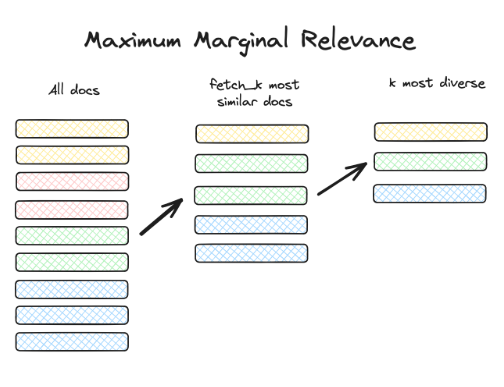

心法: 從一堆像的文件中找彼此最不像的

[Maximal Marginal Relevance to Re-rank results in Unsupervised KeyPhrase Extraction]
https://medium.com/tech-that-works/maximal-marginal-relevance-to-rerank-results-in-unsupervised-keyphrase-extraction-22d95015c7c5


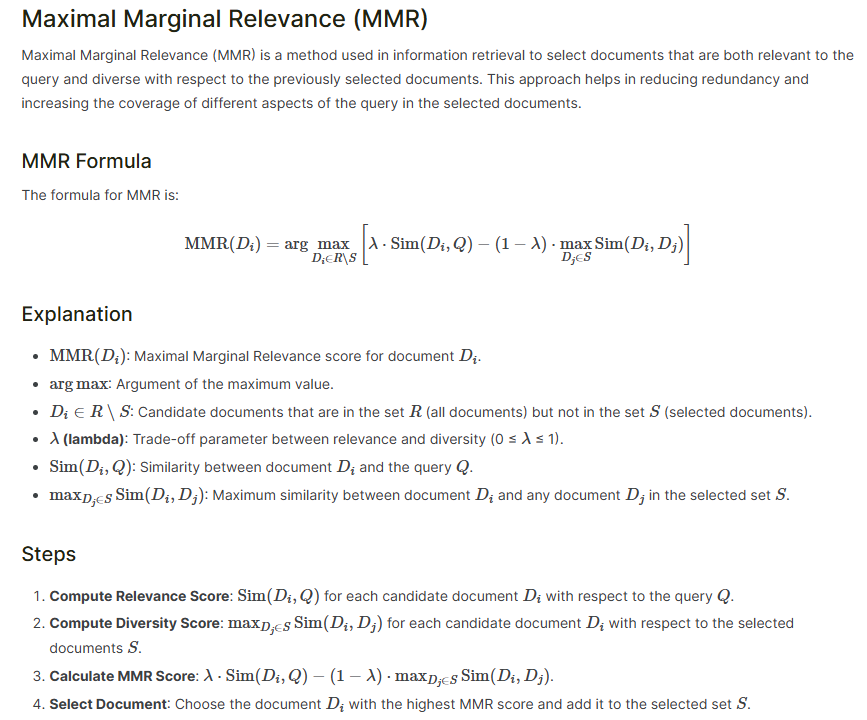

In [ ]:
class MMRSelector:
    """
    Maximal Marginal Relevance (MMR) 選擇器
    用於在保持相關性的同時增加結果的多樣性
    """
    
    def __init__(self, lambda_param=0.5):
        """
        初始化 MMR 選擇器
        
        Args:
            lambda_param (float): 平衡相關性和多樣性的參數，範圍 [0,1]
                                 0 = 只考慮多樣性，1 = 只考慮相關性
        """
        self.lambda_param = lambda_param
    
    def calculate_mmr_score(self, query_embedding, candidate_embedding, selected_embeddings):
        """
        計算 MMR 分數
        
        Args:
            query_embedding: 查詢的向量表示
            candidate_embedding: 候選文檔的向量表示
            selected_embeddings: 已選擇文檔的向量表示列表
        
        Returns:
            float: MMR 分數
        """
        # 計算與查詢的相似度 (相關性)
        relevance_score = cosine_similarity([query_embedding], [candidate_embedding])[0][0]
        
        # 計算與已選擇文檔的最大相似度 (多樣性)
        if not selected_embeddings:
            diversity_score = 0
        else:
            similarities = [
                cosine_similarity([candidate_embedding], [selected_emb])[0][0] 
                for selected_emb in selected_embeddings
            ]
            diversity_score = max(similarities)
        
        # MMR 分數公式
        mmr_score = self.lambda_param * relevance_score - (1 - self.lambda_param) * diversity_score
        
        return mmr_score
    
    def select_diverse_examples(self, query_embedding, candidates_data, n_results=10):
        """
        使用 MMR 選擇多樣化的範例
        
        Args:
            query_embedding: 查詢的向量表示
            candidates_data: 候選數據，包含 embeddings 和對應的文檔
            n_results: 要選擇的結果數量
        
        Returns:
            list: 選擇的文檔列表
        """
        candidates = candidates_data['documents'][0]
        candidate_embeddings = candidates_data.get('embeddings', [])
        
        if not candidate_embeddings:
            # 如果沒有 embeddings，回退到原始順序
            return candidates[:n_results]
        
        selected_docs = []
        selected_embeddings = []
        remaining_indices = list(range(len(candidates)))
        
        for _ in range(min(n_results, len(candidates))):
            if not remaining_indices:
                break
                
            best_score = float('-inf')
            best_idx = None
            
            for idx in remaining_indices:
                candidate_emb = candidate_embeddings[idx]
                score = self.calculate_mmr_score(
                    query_embedding, 
                    candidate_emb, 
                    selected_embeddings
                )
                
                if score > best_score:
                    best_score = score
                    best_idx = idx
            
            if best_idx is not None:
                selected_docs.append(candidates[best_idx])
                selected_embeddings.append(candidate_embeddings[best_idx])
                remaining_indices.remove(best_idx)
        
        return selected_docs


In [ ]:
class ChainOfThoughtGenerator:
    """自動生成思維鏈 (Chain of Thought) 的類別"""
    
    def __init__(self):
        self.cot_prompt_template = """
請為以下書籍分類任務生成詳細的思考過程。請遵循以下格式：

1. 分析書名中的關鍵詞
2. 分析描述中的技術關鍵字
3. 判斷主要領域和應用場景
4. 得出最終分類結論

書籍資訊：
書名: {title}
描述: {description}

請提供步驟式的思考過程，最後給出分類結果。
"""
    
    def generate_cot_for_example(self, title, description, category):
        """為訓練範例生成思維鏈"""
        messages = [
            {
                "role": "system",
                "content": "你是一個專業的書籍分類專家。請為給定的書籍生成詳細的分類思考過程。"
            },
            {
                "role": "user",
                "content": self.cot_prompt_template.format(
                    title=title,
                    description=description[:200] + "..." if len(description) > 200 else description
                )
            },
            {
                "role": "user",
                "content": f"正確答案應該是：{category}"
            }
        ]
        
        return get_completion(messages, temperature=0.3)


In [ ]:
class MedpromptExtended:
    """
    擴展的 Medprompt 實現
    整合 MMR、Dynamic Few-shots、CoT 和 Ensemble Voting
    """
    
    def __init__(self, lambda_param=0.5, ensemble_size=5):
        self.mmr_selector = MMRSelector(lambda_param)
        self.cot_generator = ChainOfThoughtGenerator()
        self.ensemble_size = ensemble_size
        self.categories = [
            "程式語言", "Data Science", "人工智慧", "分散式架構", "系統開發",
            "行動軟體開發", "資料庫", "資訊科學", "軟體架構", "軟體測試",
            "軟體工程", "資訊安全", "網站開發", "前端開發", "架站軟體",
            "網頁設計", "Adobe 軟體應用", "Office 系列", "遊戲開發設計",
            "UI/UX", "雲端運算", "區塊鏈與金融科技", "物聯網 IoT",
            "商業管理類", "電子電路電機類", "嵌入式系統", "視覺影音設計",
            "考試認證", "數學", "微軟技術", "MAC OS 蘋果電腦", "其他",
            "兒童專區", "製圖軟體應用", "語言學習", "國家考試", "職涯發展",
            "Java", "理工類", "網路通訊", "量子電腦"
        ]
    
    def shuffle_choices(self, categories):
        """隨機打亂選項順序（Choice Shuffling）"""
        shuffled = categories.copy()
        random.shuffle(shuffled)
        return shuffled
    
    def create_few_shot_prompt_with_cot(self, examples, include_cot=True):
        """創建包含思維鏈的 few-shot prompt"""
        prompt_parts = []
        
        for example in examples:
            lines = example.strip().split('\n')
            title_line = next((line for line in lines if '書名:' in line), '')
            desc_line = next((line for line in lines if '描述:' in line), '')
            category_line = next((line for line in lines if '分類:' in line), '')
            
            if title_line and desc_line and category_line:
                title = title_line.split('書名:')[1].strip().replace('```', '')
                description = desc_line.split('描述:')[1].strip().replace('```', '')
                category = category_line.split('分類:')[1].strip()
                
                prompt_part = f"範例：\n{title_line}\n{desc_line}"
                
                if include_cot:
                    # 生成思維鏈（實際應用中可以預先生成並緩存）
                    cot = self.generate_simple_cot(title, description, category)
                    prompt_part += f"\n思考過程：{cot}"
                
                prompt_part += f"\n{category_line}\n"
                prompt_parts.append(prompt_part)
        
        return '\n----\n'.join(prompt_parts)
    
    def generate_simple_cot(self, title, description, category):
        """生成簡化的思維鏈"""
        # 為了效率，這裡使用簡化的規則式 CoT
        key_analysis = []
        
        # 分析標題關鍵詞
        title_lower = title.lower()
        if any(keyword in title_lower for keyword in ['python', 'java', 'c++', 'c#']):
            key_analysis.append("標題包含程式語言關鍵詞")
        elif any(keyword in title_lower for keyword in ['ai', '人工智慧', 'chatgpt']):
            key_analysis.append("標題包含人工智慧相關關鍵詞")
        elif any(keyword in title_lower for keyword in ['iot', '物聯網']):
            key_analysis.append("標題包含物聯網相關關鍵詞")
        
        # 分析描述內容
        desc_lower = description.lower() if isinstance(description, str) else ""
        if '程式' in desc_lower or 'programming' in desc_lower:
            key_analysis.append("描述內容涉及程式設計")
        elif '資料科學' in desc_lower or 'data science' in desc_lower:
            key_analysis.append("描述內容涉及資料科學")
        
        if key_analysis:
            return f"根據分析：{'; '.join(key_analysis)}，判斷為{category}類別。"
        else:
            return f"綜合書名和描述內容，判斷為{category}類別。"
    
    def classify_with_ensemble(self, collection, title, description):
        """使用集成投票進行分類"""
        predictions = []
        
        for i in range(self.ensemble_size):
            # Choice shuffling - 每次隨機打亂分類選項順序
            shuffled_categories = self.shuffle_choices(self.categories)
            
            # 獲取 dynamic few-shot examples with MMR
            query_text = f"""
            書名: ```{title}```
            描述: ```{description}```
            """
            
            # 從 ChromaDB 檢索
            results = collection.query(
                query_embeddings=get_embeddings(query_text),
                n_results=20,  # 檢索更多候選，然後用 MMR 篩選
                include=['documents', 'embeddings']
            )
            
            # 使用 MMR 選擇多樣化的範例
            query_embedding = get_embeddings(query_text)
            diverse_examples = self.mmr_selector.select_diverse_examples(
                query_embedding, results, n_results=8
            )
            
            # 創建 prompt
            context = self.create_few_shot_prompt_with_cot(diverse_examples, include_cot=True)
            categories_str = ', '.join(shuffled_categories)
            
            messages = [
                {
                    "role": "system",
                    "content": f"""請根據以下書籍資訊，選擇最適合的技能分類。請先進行步驟式思考，然後給出分類結果。

分類選項：{categories_str}

請使用以下格式回答：
思考過程：[你的分析過程]
最終分類：[選擇的分類]

只能選擇上述分類中的一個，回答格式必須包含「最終分類：」。"""
                },
                {
                    "role": "user",
                    "content": context
                },
                {
                    "role": "user",
                    "content": f"""
                    書名: ```{title}```
                    描述: ```{description[:100]}...```
                    
                    請進行分類："""
                }
            ]
            
            response = get_completion(messages, model="gpt-4-mini", temperature=0.2 + i * 0.1)
            
            # 提取分類結果
            prediction = self.extract_classification(response)
            if prediction:
                predictions.append(prediction)
        
        # 多數投票
        if predictions:
            vote_counts = Counter(predictions)
            final_prediction = vote_counts.most_common(1)[0][0]
            confidence = vote_counts[final_prediction] / len(predictions)
            return final_prediction, confidence, predictions
        else:
            return "其他", 0.0, []
    
    def extract_classification(self, response):
        """從回應中提取分類結果"""
        if "最終分類：" in response:
            parts = response.split("最終分類：")
            if len(parts) > 1:
                prediction = parts[1].strip().split('\n')[0].strip()
                # 確保預測結果在有效分類中
                if prediction in self.categories:
                    return prediction
        
        # 備用方案：檢查回應中是否包含任何有效分類
        for category in self.categories:
            if category in response:
                return category
        
        return None

In [ ]:
def setup_vector_database():
    """設置向量資料庫"""
    print("設置向量資料庫...")
    chroma_client = chromadb.Client()
    
    try:
        collection = chroma_client.create_collection(name="books_medprompt_extended")
    except:
        chroma_client.delete_collection(name="books_medprompt_extended")
        collection = chroma_client.create_collection(name="books_medprompt_extended")
    
    return collection

In [ ]:
def load_training_data(collection, csv_file="books-dataset-107.csv"):
    """載入訓練數據到向量資料庫"""
    print("載入訓練數據...")
    try:
        df = pd.read_csv(csv_file)
        print(f"載入了 {len(df)} 筆訓練數據")
        
        for index, row in df.iterrows():
            # 這是要索引的內容
            index_text = f"""
            書名: ```{row["title"]}```
            描述: ```{str(row["description"])[:200]}```
            """
            
            # 這是對應的文字內容
            doc_text = f"""
            書名: ```{row["title"]}```
            描述: ```{row["description"]}```
            分類: {row["category"]}
            """
            
            try:
                embedding = get_embeddings(index_text)
                collection.add(
                    documents=doc_text,
                    embeddings=embedding,
                    ids=f"book-{index}"
                )
            except Exception as e:
                print(f"處理第 {index} 筆數據時出錯: {e}")
                continue
                
        print("訓練數據載入完成")
        return True
        
    except FileNotFoundError:
        print(f"找不到訓練數據檔案: {csv_file}")
        return False
    except Exception as e:
        print(f"載入訓練數據時出錯: {e}")
        return False

In [ ]:
def evaluate_model(medprompt, collection, test_csv="books-dataset-33.csv"):
    """評估模型效能"""
    print("開始評估模型...")
    try:
        df_test = pd.read_csv(test_csv)
        print(f"載入了 {len(df_test)} 筆測試數據")
        
        correct_predictions = 0
        total_predictions = 0
        detailed_results = []
        
        for index, row in df_test.iterrows():
            if pd.isna(row["description"]):
                continue
                
            print(f"處理第 {index+1}/{len(df_test)} 筆測試數據...")
            
            try:
                prediction, confidence, all_predictions = medprompt.classify_with_ensemble(
                    collection, row["title"], str(row["description"])
                )
                
                is_correct = prediction == row["category"]
                if is_correct:
                    correct_predictions += 1
                
                total_predictions += 1
                
                detailed_results.append({
                    'title': row["title"],
                    'true_category': row["category"],
                    'predicted_category': prediction,
                    'confidence': confidence,
                    'all_predictions': all_predictions,
                    'is_correct': is_correct
                })
                
                print(f"真實: {row['category']}, 預測: {prediction}, 正確: {is_correct}, 信心: {confidence:.2f}")
                
            except Exception as e:
                print(f"處理第 {index} 筆測試數據時出錯: {e}")
                continue
        
        # 計算準確率
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        print(f"\n最終準確率: {accuracy:.2%} ({correct_predictions}/{total_predictions})")
        
        return accuracy, detailed_results
        
    except FileNotFoundError:
        print(f"找不到測試數據檔案: {test_csv}")
        return 0, []
    except Exception as e:
        print(f"評估模型時出錯: {e}")
        return 0, []

In [ ]:
def analyze_results(detailed_results):
    """分析詳細結果"""
    print("\n=== 結果分析 ===")
    
    # 信心度分析
    confidences = [r['confidence'] for r in detailed_results]
    print(f"平均信心度: {np.mean(confidences):.3f}")
    print(f"信心度標準差: {np.std(confidences):.3f}")
    
    # 按信心度分組的準確率
    high_conf = [r for r in detailed_results if r['confidence'] >= 0.6]
    medium_conf = [r for r in detailed_results if 0.4 <= r['confidence'] < 0.6]
    low_conf = [r for r in detailed_results if r['confidence'] < 0.4]
    
    print(f"\n高信心度 (≥0.6): {len(high_conf)} 筆，準確率: {np.mean([r['is_correct'] for r in high_conf]):.2%}")
    print(f"中信心度 (0.4-0.6): {len(medium_conf)} 筆，準確率: {np.mean([r['is_correct'] for r in medium_conf]) if medium_conf else 0:.2%}")
    print(f"低信心度 (<0.4): {len(low_conf)} 筆，準確率: {np.mean([r['is_correct'] for r in low_conf]) if low_conf else 0:.2%}")
    
    # 錯誤分析
    errors = [r for r in detailed_results if not r['is_correct']]
    if errors:
        print(f"\n錯誤案例數: {len(errors)}")
        print("前 5 個錯誤案例:")
        for i, error in enumerate(errors[:5]):
            print(f"{i+1}. 標題: {error['title'][:50]}...")
            print(f"   真實: {error['true_category']}, 預測: {error['predicted_category']}")
            print(f"   信心: {error['confidence']:.2f}")


In [ ]:
def main():
    """主程式"""
    print("=== Medprompt Extended 書籍分類系統 ===")
    
    # 設置向量資料庫
    collection = setup_vector_database()
    
    # 載入訓練數據
    if not load_training_data(collection):
        print("無法載入訓練數據，程式結束")
        return
    
    # 初始化 Medprompt 擴展模型
    print("\n初始化 Medprompt Extended 模型...")
    medprompt = MedpromptExtended(lambda_param=0.7, ensemble_size=3)
    
    # 評估模型
    accuracy, detailed_results = evaluate_model(medprompt, collection)
    
    if detailed_results:
        # 分析結果
        analyze_results(detailed_results)
        
        # 保存詳細結果
        results_df = pd.DataFrame(detailed_results)
        results_df.to_csv("medprompt_extended_results.csv", index=False, encoding='utf-8')
        print(f"\n詳細結果已保存到 medprompt_extended_results.csv")
    
    print("\n=== 評估完成 ===")

In [ ]:
def demo_single_classification():
    """示範單一分類的詳細過程"""
    print("\n=== 單一分類示範 ===")
    
    # 設置
    collection = setup_vector_database()
    load_training_data(collection)
    medprompt = MedpromptExtended(lambda_param=0.7, ensemble_size=3)
    
    # 示範案例
    demo_book = {
        "title": "深度學習與 TensorFlow 實戰",
        "description": "本書介紹深度學習的核心概念，包括神經網絡、卷積神經網絡、循環神經網絡等，並使用 TensorFlow 框架進行實作。適合想要學習人工智慧和機器學習的開發者。"
    }
    
    print(f"示範書籍: {demo_book['title']}")
    print(f"描述: {demo_book['description']}")
    
    prediction, confidence, all_predictions = medprompt.classify_with_ensemble(
        collection, demo_book['title'], demo_book['description']
    )
    
    print(f"\n最終預測: {prediction}")
    print(f"信心度: {confidence:.2f}")
    print(f"所有預測: {all_predictions}")
    print(f"預測一致性: {Counter(all_predictions)}")

if __name__ == "__main__":
    # 執行主程式
    main()
    
    # 可選：執行單一分類示範
    # demo_single_classification() 